# Description

TODO

- rename this file to be 27-

This file is actually the same as `05-gls-qqplot.ipynb` but in python; pick one of them.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf

# Settings

In [2]:
N_PHENOTYPES = 100
N_LVS = 987

In [3]:
# INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier" / "gls"
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier"  # / "gls-gtex-mashr-mean_gene_expr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier')

# Functions

In [4]:
def show_prop(data, frac=0.05):
    _pvalue_lt_frac = data[data["pvalue"] < frac]
    #     display(_pvalue_lt_frac.head())
    return _pvalue_lt_frac.shape[0] / data.shape[0]

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    #     display(_pvalue_lt_frac.head())
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [7]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

# Standard model (no correlation matrix/identity matrix)

In [8]:
input_directory = INPUT_DIR / "gls-gtex-mashr-identity"
display(input_directory)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity')

## Get files list

In [9]:
INPUT_FILES = list(input_directory.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity/random.pheno86-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity/random.pheno53-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity/random.pheno34-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity/random.pheno93-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-identity/random.pheno92-combined-gls_phenoplier.tsv.gz')]

## Load data

In [10]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [11]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

100

In [12]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [13]:
dfs.shape

(98700, 4)

In [14]:
dfs.head()

,lv,coef,pvalue,phenotype
0,LV1,-0.006849,0.708715,random.pheno86
1,LV10,0.016397,0.094111,random.pheno86
2,LV100,0.011404,0.180058,random.pheno86
3,LV101,-0.005094,0.658657,random.pheno86
4,LV102,0.005578,0.327218,random.pheno86


In [15]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

In [16]:
show_prop(dfs)

0.061357649442755825

## Summary

In [17]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data["pvalue"], 0.01),
            "5": get_prop(lv_data["pvalue"], 0.05),
            "10": get_prop(lv_data["pvalue"], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [18]:
summary_df.shape

(987, 4)

In [19]:
summary_df.head()

,lv,1,5,10
0,LV1,0.00,0.06,0.08
1,LV10,0.00,0.03,0.06
2,LV100,0.02,0.03,0.07
3,LV101,0.01,0.05,0.09
4,LV102,0.01,0.04,0.09


In [20]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016616,0.061358,0.110628
std,0.014246,0.027557,0.038420
min,0.000000,0.000000,0.020000
25%,0.010000,0.040000,0.080000
50%,0.010000,0.060000,0.110000
75%,0.020000,0.080000,0.140000
max,0.100000,0.160000,0.240000


In [21]:
summary_df[summary_df["5"] > 0.08].sort_values("5")

,lv,1,5,10
491,LV541,0.04,0.09,0.11
638,LV674,0.03,0.09,0.11
649,LV684,0.03,0.09,0.16
661,LV695,0.03,0.09,0.16
683,LV714,0.02,0.09,0.11
...,...,...,...,...
633,LV67,0.04,0.14,0.19
150,LV234,0.07,0.15,0.21
830,LV847,0.10,0.15,0.19
487,LV538,0.06,0.15,0.17


## LV16

In [22]:
# results = dfs[dfs["phenotype"] == "random.pheno100"]  # .sample(n=100)
results = dfs[dfs["lv"] == "LV16"]  # .sample(n=100)

In [23]:
results.shape

(100, 4)

In [24]:
results.head()

,lv,coef,pvalue,phenotype
67,LV16,-0.009992,0.788682,random.pheno86
1054,LV16,-0.009689,0.781568,random.pheno53
2041,LV16,0.004283,0.365528,random.pheno34
3028,LV16,0.008214,0.254908,random.pheno93
4015,LV16,0.014759,0.118124,random.pheno92


### Proportion pvalue < 0.05

In [25]:
show_prop(results, 0.01)

0.07

In [26]:
show_prop(results, 0.05)

0.16

In [27]:
show_prop(results, 0.10)

0.22

In [28]:
show_prop(results, 0.15)

0.25

In [29]:
show_prop(results, 0.20)

0.32

### QQplot

In [30]:
data = results["pvalue"].to_numpy()
n = data.shape[0]
uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])

In [31]:
display(data[:5])
display(uniform_data[:5])

array([0.78868222, 0.78156835, 0.36552751, 0.2549084 , 0.1181244 ])

array([0.00990099, 0.01980198, 0.02970297, 0.03960396, 0.04950495])

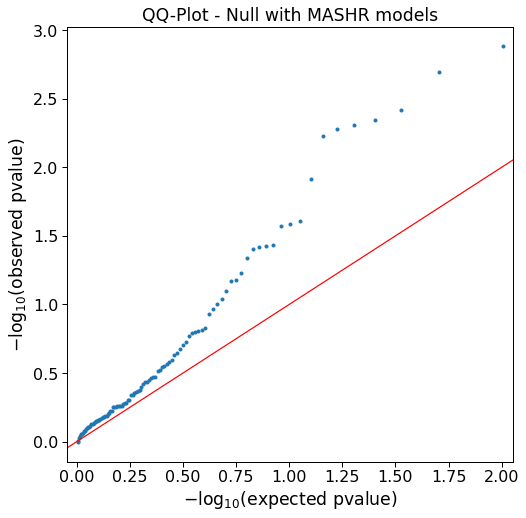

In [32]:
observed_data = -np.log10(data)
expected_data = -np.log10(uniform_data)

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel("$-\log_{10}$(expected pvalue)")
    ax.set_ylabel("$-\log_{10}$(observed pvalue)")
    ax.set_title("QQ-Plot - Null with MASHR models")

## LV110

In [33]:
results = dfs[dfs["lv"] == "LV110"]

In [34]:
results.shape

(100, 4)

In [35]:
results.head()

,lv,coef,pvalue,phenotype
13,LV110,-0.007562,0.728030,random.pheno86
1000,LV110,0.015420,0.107962,random.pheno53
1987,LV110,-0.002432,0.577364,random.pheno34
2974,LV110,-0.017334,0.917899,random.pheno93
3961,LV110,-0.012974,0.851104,random.pheno92


### Proportion pvalue < 0.05

In [36]:
show_prop(results, 0.01)

0.06

In [37]:
show_prop(results, 0.05)

0.13

In [38]:
show_prop(results, 0.10)

0.17

In [39]:
show_prop(results, 0.15)

0.18

In [40]:
show_prop(results, 0.20)

0.22

## LV121

In [41]:
results = dfs[dfs["lv"] == "LV121"]

In [42]:
results.shape

(100, 4)

In [43]:
results.head()

,lv,coef,pvalue,phenotype
25,LV121,0.010020,0.210677,random.pheno86
1012,LV121,0.008118,0.257376,random.pheno53
1999,LV121,-0.001901,0.560619,random.pheno34
2986,LV121,0.000677,0.478351,random.pheno93
3973,LV121,0.023668,0.028746,random.pheno92


### Proportion pvalue < 0.05

In [44]:
show_prop(results, 0.01)

0.0

In [45]:
show_prop(results, 0.05)

0.14

In [46]:
show_prop(results, 0.10)

0.17

In [47]:
show_prop(results, 0.15)

0.24

In [48]:
show_prop(results, 0.20)

0.29

# SSM corr values only

In [33]:
input_directory = INPUT_DIR / "gls-gtex-mashr-ssm_corrs"
display(input_directory)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs')

## Get files list

In [34]:
INPUT_FILES = list(
    f
    for f in input_directory.glob("*.tsv.gz")
    if int(f.name.split("random.pheno")[1].split("-")[0]) < 100
)
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs/random.pheno86-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs/random.pheno53-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs/random.pheno34-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs/random.pheno93-combined-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-gtex-mashr-ssm_corrs/random.pheno92-combined-gls_phenoplier.tsv.gz')]

## Load data

In [35]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [36]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

100

In [37]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [38]:
dfs.shape

(98700, 4)

In [39]:
dfs.head()

,lv,coef,pvalue,phenotype
0,LV1,-0.013093,0.858856,random.pheno86
1,LV10,0.011730,0.170973,random.pheno86
2,LV100,0.005009,0.341595,random.pheno86
3,LV101,-0.005143,0.662068,random.pheno86
4,LV102,0.006215,0.308932,random.pheno86


In [40]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

In [41]:
show_prop(dfs)

0.0680952380952381

## Summary

In [42]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data["pvalue"], 0.01),
            "5": get_prop(lv_data["pvalue"], 0.05),
            "10": get_prop(lv_data["pvalue"], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [43]:
summary_df.shape

(987, 4)

In [44]:
summary_df.head()

,lv,1,5,10
0,LV1,0.01,0.09,0.11
1,LV10,0.02,0.02,0.07
2,LV100,0.02,0.04,0.07
3,LV101,0.01,0.04,0.10
4,LV102,0.01,0.04,0.08


In [45]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.019179,0.068095,0.117447
std,0.015268,0.029987,0.038661
min,0.000000,0.010000,0.020000
25%,0.010000,0.050000,0.090000
50%,0.020000,0.070000,0.120000
75%,0.030000,0.090000,0.140000
max,0.100000,0.180000,0.250000


In [46]:
summary_df[summary_df["5"] > 0.08].sort_values("5")

,lv,1,5,10
0,LV1,0.01,0.09,0.11
557,LV600,0.01,0.09,0.14
507,LV556,0.01,0.09,0.14
496,LV546,0.03,0.09,0.11
491,LV541,0.04,0.09,0.16
...,...,...,...,...
986,LV99,0.04,0.15,0.21
324,LV391,0.09,0.16,0.20
25,LV121,0.00,0.16,0.20
67,LV16,0.06,0.17,0.21


## LV16

In [50]:
summary_df[summary_df["lv"] == "LV16"]

,lv,1,5,10
67,LV16,0.06,0.17,0.21


In [23]:
# results = dfs[dfs["phenotype"] == "random.pheno100"]  # .sample(n=100)
results = dfs[dfs["lv"] == "LV389"]  # .sample(n=100)

In [24]:
results.shape

(200, 4)

In [25]:
results.head()

,lv,coef,pvalue,phenotype
321,LV389,0.009703,0.219513,random.pheno86
1308,LV389,0.004813,0.351040,random.pheno53
2295,LV389,0.033391,0.003792,random.pheno34
3282,LV389,0.024447,0.025918,random.pheno177
4269,LV389,0.018315,0.071991,random.pheno93


### Proportion pvalue < 0.05

In [26]:
show_prop(results, 0.01)

0.045

In [27]:
show_prop(results, 0.05)

0.125

In [28]:
show_prop(results, 0.10)

0.17

In [29]:
show_prop(results, 0.15)

0.22

In [30]:
show_prop(results, 0.20)

0.26

### QQplot

In [31]:
data = results["pvalue"].to_numpy()
n = data.shape[0]
uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])

In [32]:
display(data[:5])
display(uniform_data[:5])

array([0.21951253, 0.35103972, 0.00379187, 0.02591801, 0.07199116])

array([0.00497512, 0.00995025, 0.01492537, 0.0199005 , 0.02487562])

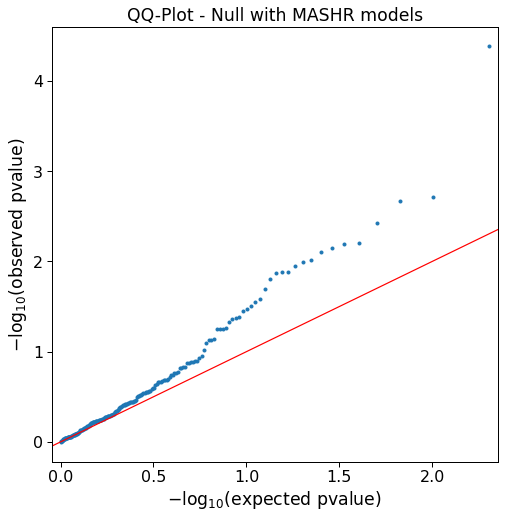

In [33]:
observed_data = -np.log10(data)
expected_data = -np.log10(uniform_data)

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel("$-\log_{10}$(expected pvalue)")
    ax.set_ylabel("$-\log_{10}$(observed pvalue)")
    ax.set_title("QQ-Plot - Null with MASHR models")

# MAGMA-derived correaltions between two genes

# Mean correlation between principal components

# See what's going on with LV704?

In [24]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [25]:
multiplier_z.shape

(6750, 987)

In [26]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
GAS6,0.000000,0.0,0.039438,0.0,0.050476,0.000000,0.0,0.000000,0.590949,0.000000,...,0.050125,0.00000,0.033407,0.000000,0.000000,0.005963,0.347362,0.0,0.000000,0.000000
MMP14,0.000000,0.0,0.000000,0.0,0.070072,0.000000,0.0,0.004904,1.720179,2.423595,...,0.000000,0.00000,0.001007,0.000000,0.035747,0.000000,0.000000,0.0,0.014978,0.000000
DSP,0.000000,0.0,0.000000,0.0,0.000000,0.041697,0.0,0.005718,0.000000,0.000000,...,0.020853,0.00000,0.000000,0.000000,0.000000,0.005774,0.000000,0.0,0.000000,0.416405
MARCKSL1,0.305212,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.161843,0.149471,...,0.027134,0.05272,0.000000,0.030189,0.060884,0.000000,0.000000,0.0,0.000000,0.448480
SPARC,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.014014,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.067779,0.0,0.122417,0.062665


In [27]:
multiplier_z["LV704"].sort_values(ascending=False).head(20)

CDC25A      7.663420
EIF3A       4.580440
MAT2B       4.225408
FGFR1OP     3.548053
CEP63       3.547427
RAB4A       2.459242
DYNLRB1     1.964849
TAF1B       1.498529
VTI1A       1.481292
DDX42       1.358032
DNAJA2      1.332558
NDUFS4      1.321993
PSMD14      1.308596
YWHAB       1.291895
CHMP5       1.190785
PTPN11      1.113178
TMEM117     1.079425
UGCG        1.036380
SLC25A12    0.982376
PRPF19      0.980791
Name: LV704, dtype: float64

In [28]:
# LV1 is an example of a good "LV" with good type I error rates
multiplier_z["LV1"].sort_values(ascending=False).head(20)

POLD1      2.989508
TRIM28     2.967235
TOMM40     2.941369
PKMYT1     2.810091
CDT1       2.776054
VARS       2.533207
H2AFX      2.502205
KHSRP      2.499231
MCM2       2.493689
TONSL      2.466507
INCENP     2.422455
CAD        2.372358
U2AF2      2.367987
MYBL2      2.349290
SF3A2      2.246600
NOC2L      2.237970
MYBBP1A    2.220894
HMGA1      2.203837
POLRMT     2.179883
E2F1       2.158240
Name: LV1, dtype: float64

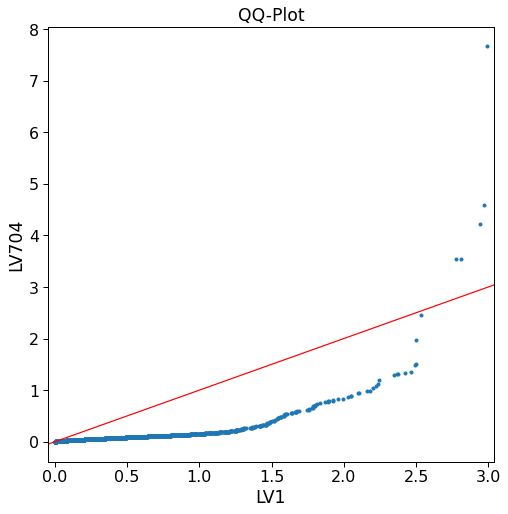

In [35]:
lv_x = "LV1"
lv_y = "LV704"

observed_data = multiplier_z[lv_y].to_numpy()
expected_data = multiplier_z[lv_x].to_numpy()

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel(lv_x)
    ax.set_ylabel(lv_y)
    ax.set_title("QQ-Plot")

For LV704, most of the gene values are zero, and just a few have higher values.

The same happens with LV100 (below)

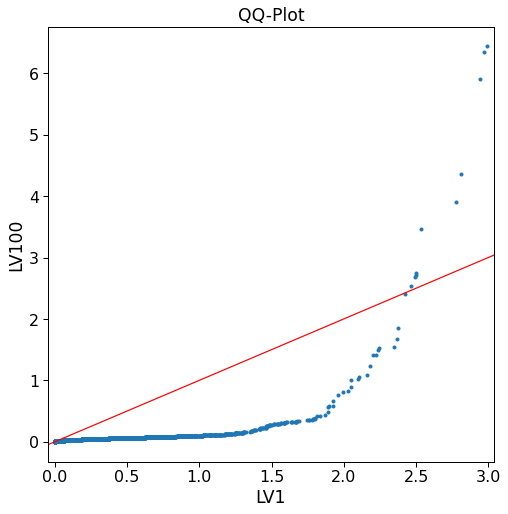

In [36]:
# two good LVs
lv_x = "LV1"
lv_y = "LV100"

observed_data = multiplier_z[lv_y].to_numpy()
expected_data = multiplier_z[lv_x].to_numpy()

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel(lv_x)
    ax.set_ylabel(lv_y)
    ax.set_title("QQ-Plot")

But LV100 has good type I error rates, compared with LV704. So what's the difference? **Maybe** the top genes in LV704 are more correlated than in LV100

## Let's see the band of genes in these two LVs

In [48]:
from data.recount2 import LVAnalysis

### LV704

In [49]:
lv704 = LVAnalysis("LV704")

In [72]:
lv704.lv_genes.head()

,gene_name,LV704,gene_band
0,CDC25A,7.663420,3p21.31
1,EIF3A,4.580440,10q26.11
2,MAT2B,4.225408,5q34
3,FGFR1OP,3.548053,6q27
4,CEP63,3.547427,3q22.2


In [75]:
_tmp = (
    lv704.lv_genes.head(50)
    .groupby("gene_band")
    .count()
    .sort_values("gene_name", ascending=False)
)
display(_tmp[_tmp["gene_name"] > 1])

,gene_name,LV704
gene_band,,
4q22.1,2,2
11q13.1,2,2


### LV1

In [68]:
lv1 = LVAnalysis("LV1")

In [71]:
lv1.lv_genes.head()

,gene_name,LV1,gene_band
0,POLD1,2.989508,19q13.33
1,TRIM28,2.967235,19q13.43
2,TOMM40,2.941369,19q13.32
3,PKMYT1,2.810091,16p13.3
4,CDT1,2.776054,16q24.3


In [74]:
_tmp = (
    lv1.lv_genes.head(50)
    .groupby("gene_band")
    .count()
    .sort_values("gene_name", ascending=False)
)
display(_tmp[_tmp["gene_name"] > 1])

,gene_name,LV1
gene_band,,
19p13.3,7,7
11q13.1,3,3
16p13.3,2,2
1p36.33,2,2
19q13.42,2,2
8q24.3,2,2
20q11.22,2,2
17p13.2,2,2


Hm, this is not what I expected.

Let's see the QQ plot of LV704.

# QQ-plot of LV704

In [76]:
# results = dfs[dfs["phenotype"] == "random.pheno100"]  # .sample(n=100)
results = dfs[dfs["lv"] == "LV704"]  # .sample(n=100)

In [77]:
results.shape

(400, 4)

In [78]:
results.head()

,lv,coef,pvalue,phenotype
672,LV704,-0.011607,0.953018,random.pheno86
1659,LV704,0.023877,0.000289,random.pheno210
2646,LV704,0.010405,0.065512,random.pheno357
3633,LV704,-0.007327,0.853785,random.pheno53
4620,LV704,-0.029620,0.999991,random.pheno215


## Proportion pvalue < 0.05

In [79]:
show_prop(results, 0.01)

0.225

In [80]:
show_prop(results, 0.05)

0.285

In [81]:
show_prop(results, 0.10)

0.33

In [82]:
show_prop(results, 0.15)

0.345

In [83]:
show_prop(results, 0.20)

0.3725

## Plot

In [84]:
data = results["pvalue"].to_numpy()
n = data.shape[0]
uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])

In [85]:
display(data[:5])
display(uniform_data[:5])

array([9.53017785e-01, 2.88909527e-04, 6.55117391e-02, 8.53784584e-01,
       9.99990502e-01])

array([0.00249377, 0.00498753, 0.0074813 , 0.00997506, 0.01246883])

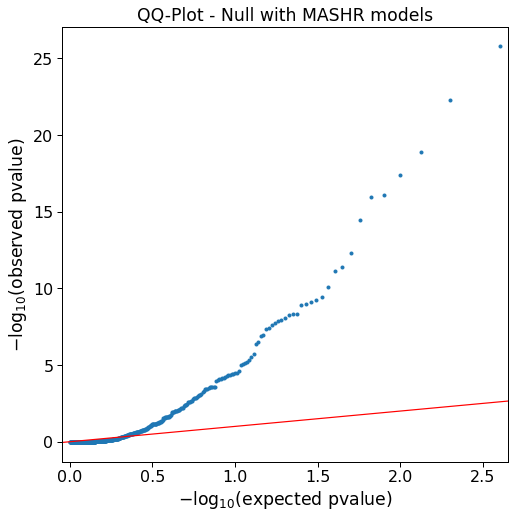

In [86]:
observed_data = -np.log10(data)
expected_data = -np.log10(uniform_data)

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel("$-\log_{10}$(expected pvalue)")
    ax.set_ylabel("$-\log_{10}$(observed pvalue)")
    ax.set_title("QQ-Plot - Null with MASHR models")

In [308]:
results.sort_values("pvalue").head(50)

,lv,coef,pvalue,phenotype
212877,LV704,0.074528,1.660890e-26,random.pheno255
159579,LV704,0.069029,5.124918e-23,random.pheno67
51009,LV704,0.063678,1.267764e-19,random.pheno359
139839,LV704,0.060420,3.962925e-18,random.pheno138
286902,LV704,0.057695,7.871688e-17,random.pheno276
35217,LV704,0.057301,1.100255e-16,random.pheno367
162540,LV704,0.054605,3.472202e-15,random.pheno307
118125,LV704,0.049593,4.748186e-13,random.pheno343
371784,LV704,0.047427,4.208621e-12,random.pheno97
87528,LV704,0.047151,7.768505e-12,random.pheno270


# Load gene correlations

In [284]:
def get_upper_triag(similarity_matrix: pd.DataFrame, k: int = 1):
    """
    It returns the upper triangular matrix of a dataframe representing a
    similarity matrix between n elements.
    Args:
        similarity_matrix: a squared dataframe with a pairwise similarity
          matrix. That means the matrix is equal to its transposed version.
        k: argument given to numpy.triu function. It indicates the that the
          elements of the k-th diagonal to be zeroed.
    Returns:
        A dataframe with non-selected elements as NaNs.
    """
    mask = np.triu(np.ones(similarity_matrix.shape), k=k).astype(bool)
    return similarity_matrix.where(mask)

In [285]:
OUT_GENE_CORRS_DIR = Path(conf.DATA_DIR, "tmp", "gene_corrs").resolve()
display(OUT_GENE_CORRS_DIR)
OUT_GENE_CORRS_DIR.mkdir(exist_ok=True, parents=True)

PosixPath('/opt/data/data/tmp/gene_corrs')

In [286]:
gene_corrs_file = (
    conf.PHENOMEXCAN["LD_BLOCKS"]["GENE_CORRS_DIR"]
    / "gtex_v8/mashr/multiplier_genes-pred_expression_corr_avg-mean-gene_symbols.pkl"
)

In [287]:
gene_corrs = pd.read_pickle(gene_corrs_file)

In [288]:
gene_corrs.shape

(6452, 6452)

In [289]:
gene_corrs.head()

id,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
id,,,,,,,,,,,,,,,,,,,,,
GAS6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MMP14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.002833,0.0,0.0,0.0,0.0,0.0
DSP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
MARCKSL1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.003401,0.0,...,0.0,0.0,0.0,0.002546,0.000000,0.0,0.0,0.0,0.0,0.0
SPARC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [290]:
get_upper_triag(gene_corrs).unstack().dropna().describe().apply(str)

count                20810926.0
mean     1.3497273130269605e-06
std        0.004250836092978716
min         -0.9172987341880798
25%                         0.0
50%                         0.0
75%                         0.0
max          0.8924158811569214
dtype: object

## Create positive only

In [291]:
gene_corrs_positive_only = OUT_GENE_CORRS_DIR / "gene_corrs-positive_only.pkl"

In [292]:
gene_corrs.min().min()

-0.91729873

In [293]:
_tmp = gene_corrs.copy()
_tmp[_tmp < 0] = 0.0

In [295]:
get_upper_triag(_tmp).unstack().dropna().describe().apply(str)

count               20810926.0
mean     0.0002564224705565721
std       0.003004679922014475
min                        0.0
25%                        0.0
50%                        0.0
75%                        0.0
max         0.8924158811569214
dtype: object

In [296]:
_tmp.to_pickle(gene_corrs_positive_only)

## Create r**2 matrix

In [297]:
gene_corrs_r2 = OUT_GENE_CORRS_DIR / "gene_corrs-r2.pkl"

In [298]:
gene_corrs.min().min()

-0.91729873

In [299]:
_tmp = np.power(gene_corrs.copy(), 2)

In [300]:
_tmp.min().min()

0.0

In [301]:
get_upper_triag(_tmp).unstack().dropna().describe().apply(str)

count               20810926.0
mean     1.806960062822327e-05
std       0.001293065375648439
min                        0.0
25%                        0.0
50%                        0.0
75%                        0.0
max         0.8414369821548462
dtype: object

In [302]:
_tmp.to_pickle(gene_corrs_r2)

## Create default gene correlations matrix

In [303]:
default_gene_corrs_file = OUT_GENE_CORRS_DIR / "gene_corrs-default_identity_matrix.pkl"

In [304]:
gene_corrs_default = pd.DataFrame(
    data=np.identity(gene_corrs.shape[0]),
    index=gene_corrs.index.copy(),
    columns=gene_corrs.columns.copy(),
)

In [305]:
gene_corrs_default.shape

(6452, 6452)

In [306]:
gene_corrs_default.head()

id,GAS6,MMP14,DSP,MARCKSL1,SPARC,CTSD,EPAS1,PALLD,PHC2,LGALS3BP,...,LDHB,LDHC,ACAP2,ACAP3,CFL2,CFL1,NFIB,PLEKHG6,GNGT2,SERPINH1
id,,,,,,,,,,,,,,,,,,,,,
GAS6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MMP14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DSP,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MARCKSL1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SPARC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [307]:
gene_corrs_default.to_pickle(default_gene_corrs_file)

# Load random.pheno255

In [152]:
# let's take a look at the MultiXcan results in random.pheno255
random_pheno_255_mx = pd.read_csv(
    conf.RESULTS["GLS_NULL_SIMS"]
    / "twas"
    / "smultixcan"
    / "random.pheno255-gtex_v8-mashr-smultixcan.txt",
    sep="\t",
)

In [153]:
random_pheno_255_mx.shape

(22317, 18)

In [154]:
random_pheno_255_mx.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000234634.1,LINC02093,0.000072,1.0,1.0,0.000072,Testis,0.000072,Testis,1.000000,1.000000e+00,1.000000,-3.969277,-3.969277,-3.969277,NaN,1.0,0
1,ENSG00000104164.10,BLOC1S6,0.000078,12.0,3.0,0.000004,Adipose_Subcutaneous,0.474198,Brain_Cerebellar_Hemisphere,7.220937,1.793227e-22,0.915740,-0.981515,4.617559,2.007790,2.003827,3.0,0
2,ENSG00000143786.7,CNIH3,0.000144,17.0,7.0,0.000224,Brain_Spinal_cord_cervical_c-1,0.761493,Artery_Aorta,5.752532,8.006265e-18,0.229252,-3.689795,1.195704,-0.533416,1.427478,7.0,0
3,ENSG00000171497.4,PPID,0.000144,49.0,3.0,0.000049,Brain_Cerebellar_Hemisphere,0.319721,Muscle_Skeletal,38.956526,1.516876e-15,1.491169,-4.058936,3.448436,-2.770213,1.679229,3.0,0
4,ENSG00000143748.17,NVL,0.000195,49.0,3.0,0.035088,Heart_Left_Ventricle,0.671017,Small_Intestine_Terminal_Ileum,34.472924,1.010101e-15,1.173867,-2.107341,1.450350,0.266461,0.885925,3.0,0


In [155]:
data = random_pheno_255_mx[["gene_name", "pvalue"]].set_index("gene_name").squeeze()

In [156]:
data.shape

(22317,)

In [157]:
data = data.loc[~data.index.duplicated(keep="first")]

In [158]:
data.shape

(22311,)

In [160]:
data = data.dropna()

In [161]:
data.shape

(22308,)

In [162]:
common_genes = data.index.intersection(multiplier_z.index).intersection(
    gene_corrs.index
)

In [163]:
len(common_genes)

6442

In [164]:
y = data.loc[common_genes]

In [165]:
y.shape

(6442,)

In [166]:
y

PPID        0.000144
ARHGAP25    0.000247
MRPL2       0.000315
RNF41       0.000697
FHIT        0.000752
              ...   
DOCK2       0.999651
NDUFB4      0.999706
COL1A1      0.999817
ARHGAP15    0.999964
SOS1        0.999974
Name: pvalue, Length: 6442, dtype: float64

QQ plot of MultiXcan results with genes only in MultiPLIER models...

In [167]:
data = y.to_numpy()
n = data.shape[0]
uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])

In [168]:
display(data[:5])
display(uniform_data[:5])

array([0.00014413, 0.00024695, 0.00031485, 0.00069724, 0.00075189])

array([0.00015521, 0.00031041, 0.00046562, 0.00062083, 0.00077604])

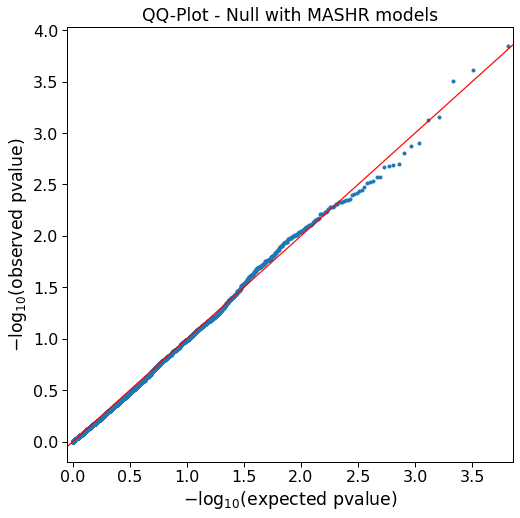

In [169]:
observed_data = -np.log10(data)
expected_data = -np.log10(uniform_data)

with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
    {"lines.markersize": 3}
):
    fig, ax = plt.subplots(figsize=(8, 8))

    fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

    ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

    ax.set_xlabel("$-\log_{10}$(expected pvalue)")
    ax.set_ylabel("$-\log_{10}$(observed pvalue)")
    ax.set_title("QQ-Plot - Null with MASHR models")

Looks good

In [171]:
# convert p-values to z-scores
y = pd.Series(data=np.abs(stats.norm.ppf(y / 2)), index=y.index.copy())

In [172]:
y.shape

(6442,)

In [174]:
y.dropna().shape

(6442,)

In [173]:
y.head()

PPID        3.800963
ARHGAP25    3.665405
MRPL2       3.602765
RNF41       3.390663
FHIT        3.369925
dtype: float64

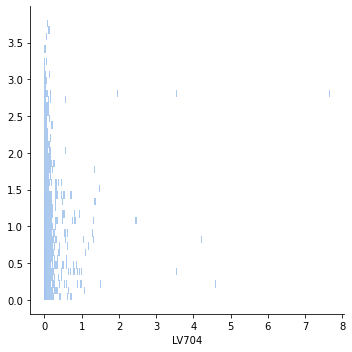

In [176]:
sns.displot(x=multiplier_z.loc[common_genes, "LV704"], y=y.loc[common_genes])

In [183]:
stats.pearsonr(multiplier_z.loc[common_genes, "LV704"], y)

(0.039680632576232944, 0.0014451098599721187)

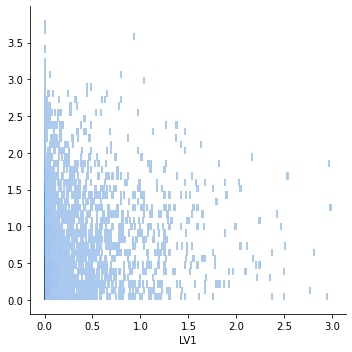

In [177]:
sns.displot(x=multiplier_z.loc[common_genes, "LV1"], y=y.loc[common_genes])

In [184]:
stats.pearsonr(multiplier_z.loc[common_genes, "LV1"], y)

(0.018370336314210846, 0.1404063516038885)

In [179]:
multiplier_z.loc[common_genes, "LV704"]

PPID        0.072310
ARHGAP25    0.121708
MRPL2       0.063188
RNF41       0.000000
FHIT        0.016550
              ...   
DOCK2       0.055976
NDUFB4      0.003612
COL1A1      0.043407
ARHGAP15    0.000000
SOS1        0.022320
Name: LV704, Length: 6442, dtype: float64

In [189]:
from gls import GLSPhenoplier

In [204]:
model = GLSPhenoplier(
    gene_corrs_file_path=gene_corrs_file,
)

model.fit_named("LV704", y)
res = model.results

print(res.summary())

                            GLS Regression Results                            
Dep. Variable:              phenotype   R-squared:                       0.017
Model:                            GLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     113.1
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           3.32e-26
Time:                        03:49:55   Log-Likelihood:                -9371.8
No. Observations:                6442   AIC:                         1.875e+04
Df Residuals:                    6440   BIC:                         1.876e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
i              0.0040      0.013      0.316      0.7

In [205]:
model = GLSPhenoplier(
    gene_corrs_file_path=default_gene_corrs_file,
)

model.fit_named("LV704", y)
res = model.results

print(res.summary())

                            GLS Regression Results                            
Dep. Variable:              phenotype   R-squared:                       0.002
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.16
Date:                Mon, 13 Jun 2022   Prob (F-statistic):            0.00145
Time:                        03:50:09   Log-Likelihood:                -9135.7
No. Observations:                6442   AIC:                         1.828e+04
Df Residuals:                    6440   BIC:                         1.829e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
i           1.507e-17      0.012   1.21e-15      1.0

**Conclusion**: If I compare the GLS model with a standard one (sigma is just the identity matrix), things do not seem to improve, actually it gets worse.

Try to

# Try with positive-only gene corr matrix

In [213]:
model = GLSPhenoplier(
    gene_corrs_file_path=gene_corrs_positive_only,
)

model.fit_named("LV704", y)
res = model.results

print(res.summary())

                            GLS Regression Results                            
Dep. Variable:              phenotype   R-squared:                       0.002
Model:                            GLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.02
Date:                Mon, 13 Jun 2022   Prob (F-statistic):            0.00156
Time:                        13:02:22   Log-Likelihood:                -9059.6
No. Observations:                6442   AIC:                         1.812e+04
Df Residuals:                    6440   BIC:                         1.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
i             -0.0008      0.018     -0.044      0.9

# Try with r2 gene corr matrix

In [226]:
model = GLSPhenoplier(
    gene_corrs_file_path=gene_corrs_r2,
)

model.fit_named("LV704", y)
res = model.results

print(res.summary())

                            GLS Regression Results                            
Dep. Variable:              phenotype   R-squared:                       0.001
Model:                            GLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.309
Date:                Mon, 13 Jun 2022   Prob (F-statistic):             0.0690
Time:                        13:05:14   Log-Likelihood:                -9060.6
No. Observations:                6442   AIC:                         1.813e+04
Df Residuals:                    6440   BIC:                         1.814e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
i             -0.0009      0.013     -0.072      0.9

In [206]:
from entity import Gene

In [207]:
gene_objs = [Gene(name=g) for g in y.index]

In [208]:
gene_objs[0]